In [ ]:
import os
import pandas as pd
from PIL import Image, ImageFile
import torch
import lpips
from torchvision import transforms
from pytorch_msssim import ms_ssim
import matplotlib.pyplot as plt
import math
import numpy as np

# ---------------- Metric Functions ----------------
def calculate_psnr(original, recon, resolution):
    transform = transforms.Compose([transforms.CenterCrop(resolution), transforms.ToTensor()])
    img1 = transform(Image.open(original).convert("RGB")).unsqueeze(0).clamp(0, 1)
    img2 = transform(Image.open(recon).convert("RGB")).unsqueeze(0).clamp(0, 1)
    mse = torch.mean((img1 - img2) ** 2)
    return float('inf') if mse == 0 else 10 * torch.log10(1.0 / mse).item()

def calculate_ms_ssim(original, recon, resolution):
    transform = transforms.Compose([transforms.CenterCrop(resolution), transforms.ToTensor()])
    img1 = transform(Image.open(original).convert("RGB")).unsqueeze(0).clamp(0, 1)
    img2 = transform(Image.open(recon).convert("RGB")).unsqueeze(0).clamp(0, 1)
    return ms_ssim(img1, img2, data_range=1.0, size_average=True).item()

def calculate_lpips(original, recon, resolution):
    model = lpips.LPIPS(net='alex')
    transform = transforms.Compose([transforms.CenterCrop(resolution), transforms.ToTensor()])
    img1 = transform(Image.open(original).convert("RGB")).unsqueeze(0)
    img2 = transform(Image.open(recon).convert("RGB")).unsqueeze(0)
    return model(img1, img2).item()

def prepare_image_path(original_path):

    MAX_DIM = 3500  # Change this value easily if needed

    ext = os.path.splitext(original_path)[-1].lower()
    with Image.open(original_path) as img:
        w, h = img.size
        needs_conversion = ext in [".jpg", ".jpeg", ".dng"]
        needs_resize = max(w, h) > MAX_DIM

        if needs_conversion or needs_resize:
            scale = MAX_DIM / max(w, h) if needs_resize else 1.0
            new_size = (int(w * scale), int(h * scale)) if needs_resize else (w, h)

            if needs_resize:
                img = img.resize(new_size, Image.LANCZOS)

            base_name = os.path.splitext(os.path.basename(original_path))[0]
            temp_path = f"{base_name}.png"

            # temp_path = "image.png"
            img.save(temp_path, format="PNG")
            # print(f"Image processed and saved to {temp_path} with size {new_size}")
            return temp_path
        else:
            return original_path


# ---------------- Model Condition Mapping ----------------
model_conditions = {
    "adaptive_codebook_4d_512k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "4", "k": "512"},
    "adaptive_codebook_4d_1024k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "4", "k": "1024"},
    "adaptive_codebook_2d_256k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "2", "k": "256"},
    "adaptive_codebook_2d_512k": {"Adaptive": "TRUE", "CodebookUsed": "TRUE", "d": "2", "k": "512"},
    "adaptive_wo_codebook": {"Adaptive": "TRUE", "CodebookUsed": "FALSE"},
    "wo_adaptive_codebook_4d_512k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "4", "k": "512"},
    "wo_adaptive_codebook_4d_1024k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "4", "k": "1024"},
    "wo_adaptive_codebook_2d_256k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "2", "k": "256"},
    "wo_adaptive_codebook_2d_512k": {"Adaptive": "FALSE", "CodebookUsed": "TRUE", "d": "2", "k": "512"},
    "wo_adaptive_wo_codebook": {"Adaptive": "FALSE", "CodebookUsed": "FALSE"},
}

# ---------------- Main Function ----------------
def compare_models(image_path, model_labels):
    df = pd.read_excel("results_summary.xlsx")
    image_path = prepare_image_path(image_path)
    image_name = os.path.splitext(os.path.basename(image_path))[0].lower()

    primary_df = df[df['ImagePath'].str.lower() == image_name].copy()
    fallback_df = df[df['ImagePath'].str.lower() == 'default_image'].copy()

    use_fallback = primary_df.empty
    df = fallback_df if use_fallback else primary_df

    if df.empty:
        print("No matching rows in Excel.")
        return

    selected = []
    for label in model_labels:
        cond = model_conditions.get(label)
        if cond is None:
            print(f"Unknown model label: {label}")
            continue

        rows = df[
            (df['Adaptive'].astype(str).str.upper() == cond['Adaptive']) &
            (df['CodebookUsed'].astype(str).str.upper() == cond['CodebookUsed'])
        ]
        # if 'd' in cond:
        #     rows = rows[rows['d'].astype(str) == cond['d']]
        # if 'k' in cond:
        #     rows = rows[rows['k'].astype(str) == cond['k']]

        if 'd' in cond:
            rows = rows[rows['d'] == int(cond['d'])]
        if 'k' in cond:
            rows = rows[rows['k'] == int(cond['k'])]

        if not rows.empty:
            selected.append((label, rows.iloc[0]))

    if not selected:
        print("No models matched.")
        return

    # --- Plot ---
    # fig, axes = plt.subplots(1, len(selected) + 1, figsize=(5 * (len(selected) + 1), 5))

    max_per_row = 3
    total_plots = len(selected) + 1  # +1 for original
    rows = math.ceil(total_plots / max_per_row)
    cols = min(total_plots, max_per_row)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    # axes = axes.flatten() if rows > 1 else [axes]  # flatten for consistent indexing
    axes = np.array(axes).flatten().tolist()



    axes[0].imshow(Image.open(image_path))
    axes[0].set_title("Original")
    axes[0].axis('off')

    for idx, (label, row) in enumerate(selected):
        recon_path = row['ReconPath']
        with Image.open(recon_path) as img:
            resolution = img.size[::-1]  # (H, W)
        binary_size = float(row['BinarySizeKB'])

        if use_fallback:
            # Calculate fresh
            psnr = calculate_psnr(image_path, recon_path, resolution)
            ssim = calculate_ms_ssim(image_path, recon_path, resolution)
            lp = calculate_lpips(image_path, recon_path, resolution)
            orig_size = os.path.getsize(image_path) / 1024
            cr = orig_size / binary_size if binary_size else 0
        else:
            psnr = row['PSNR']
            ssim = row['MS-SSIM']
            lp = row['LPIPS']
            cr = row['CompressionRatio']

        axes[idx + 1].imshow(Image.open(recon_path))
        axes[idx + 1].set_title(
            f"{label}\nPSNR: {psnr:.2f} dB\nMS-SSIM: {ssim:.4f}\nLPIPS: {lp:.4f}\nCompression Ratio: {cr:.2f}"
        )
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# compare_models(
#     "Datasets/Kodak/kodim23.png",
#     [
#         "wo_adaptive_wo_codebook",
#         "wo_adaptive_codebook_4d_512k",
#         "wo_adaptive_codebook_2d_256k",
#         "adaptive_codebook_4d_512k",
#         "adaptive_codebook_2d_256k",
#         "adaptive_wo_codebook",
#     ]
# )


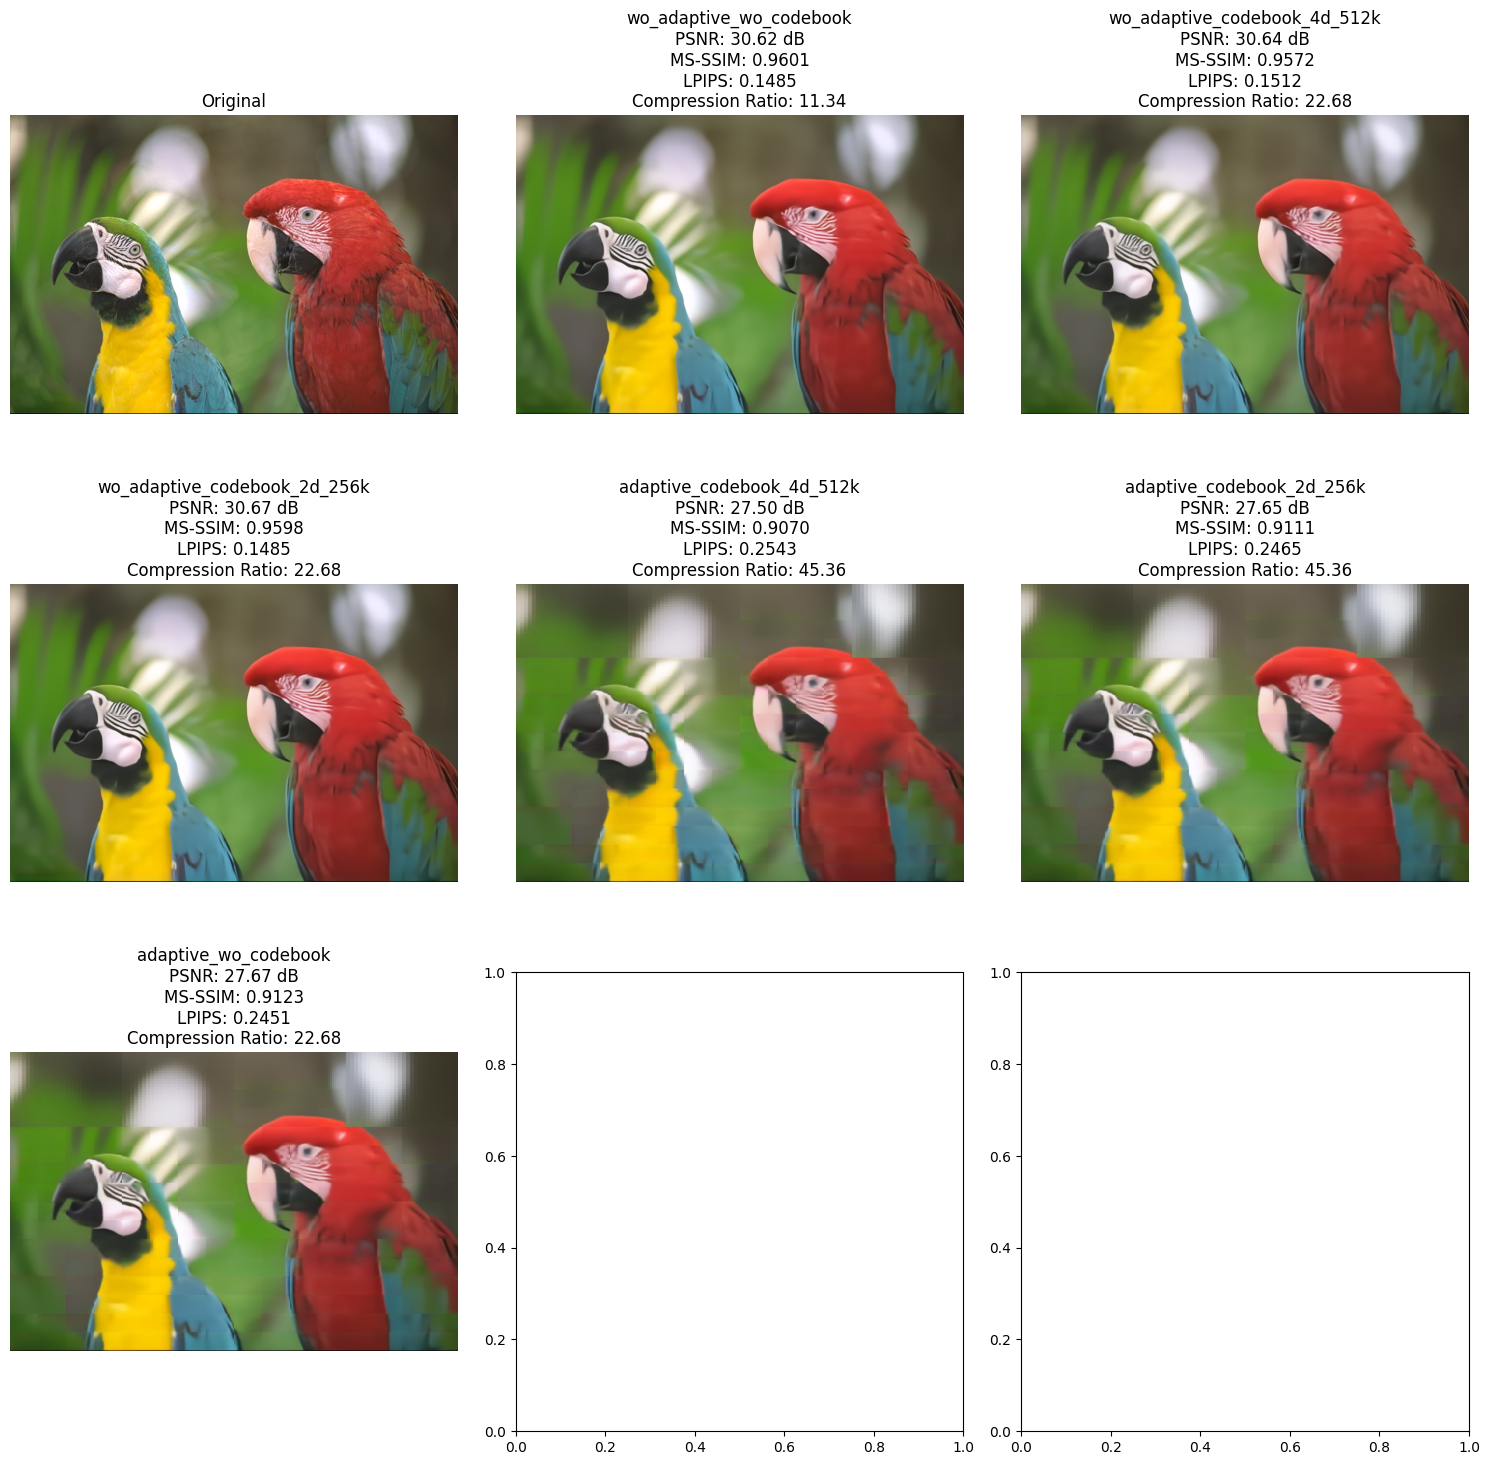

In [20]:
compare_models(
    "Datasets/Kodak/kodim23.png",
    [
        "wo_adaptive_wo_codebook",
        "wo_adaptive_codebook_4d_512k",
        "wo_adaptive_codebook_2d_256k",
        "adaptive_codebook_4d_512k",
        "adaptive_codebook_2d_256k",
        "adaptive_wo_codebook",
    ]
)
